<a href="https://colab.research.google.com/github/aleCastanheira/TCC_MBA/blob/main/process_metadata_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

O setup basicamente consiste nos imports, na definição de constantes e na leitura do arquivo de metadados.

In [183]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings

warnings.filterwarnings("ignore")

In [185]:
# CONSTANTES DO SCRIPT
FILEPATH = "/content/drive/MyDrive/TCC"
valid_tables_path = f"{FILEPATH}/valid_tables.json"
ORIGIN_METADATA_FILE = "metadata_file.csv"
PROCESSED_METADATA_FILE = "processed_metadata.csv"
PROCESSED_METADATA_OUTLIERS_FILE = "processed_metadata_outliers.csv"
ORIGIN_METADATA_FILEPATH = f"{FILEPATH}/{ORIGIN_METADATA_FILE}"
PROCESSED_METADATA_FILEPATH = f"{FILEPATH}/{PROCESSED_METADATA_FILE}"
PROCESSED_METADATA_OUTLIERS_FILEPATH = f"{FILEPATH}/{PROCESSED_METADATA_OUTLIERS_FILE}"

# Chave da coluna anonimizada:
ANNON_TABLE_KEY = "annon_table"

PATH = "path"
FULL_FILENAME = "full_filename"
KEY = "key"
ROOT_KEY = "root_dir"
EXTENSION_KEY = "extension"
COMPRESSION_KEY = "compression"
FILENAME_KEY = "filename"
BUCKET_KEY = "bucket"
SIZE_KEY = "size"
MODIFIED_KEY = "last_modified"
TABLE_KEY = "table"
REF_DATE_KEY = "reference_date"
PARTITION_DATE_KEY = "partition_date"
REFERENCE_TABLE_KEY = "reference_table"

# CAMPOS DE PARTIÇÃO POR DATA
PARTITION_DAY = "day"
PARTITION_MONTH = "month"
PARTITION_YEAR = "year"
DATE_PARTITION_LIST = (PARTITION_DAY, PARTITION_MONTH, PARTITION_YEAR)

# campos que se houver algum valor nulo, é uma linha invpalida
REQUIRED_FIELDS = [BUCKET_KEY, SIZE_KEY, FILENAME_KEY, REF_DATE_KEY]

# REMOVENDO LINHAS COM VALORES INVÁLIDOS
INVALID_PARTITION_NAMES_LIST = ["_temporary"]
INVALID_COMPRESSION_NAMES_LIST = ["log", "deltacommit", "archive"]
INVALID_EXTENSION_NAMES_LIST = ["gz", "deltacommit"]
INVALID_FILENAMES_LIST = ["_SUCCESS"]

ORDER_BY_COLUMNS = [TABLE_KEY, REF_DATE_KEY]
GROUP_BY_COLUMNS = [TABLE_KEY, REF_DATE_KEY]

TOTAL_FILES_KEY = 'total_files'
TOTAL_SIZE_KEY = 'total_size'

SCHEMA = {
    BUCKET_KEY: "int",
    KEY: "string",
    REFERENCE_TABLE_KEY: "string",
    ROOT_KEY: "string",
    TABLE_KEY: "string",
    REF_DATE_KEY: 'string',
    PARTITION_DATE_KEY: 'string',
    PARTITION_DAY: 'string',
    PARTITION_MONTH: 'string',
    PARTITION_YEAR: 'string',
    FILENAME_KEY: 'string',
    EXTENSION_KEY: 'string',
    COMPRESSION_KEY: 'string',
    MODIFIED_KEY: 'string',
    SIZE_KEY: "int",
}

# tabelas escolhidas para a análise
tab_list = [
    'TAB000001', # crescimento constante, sem outliers aparente
    'TAB000005', # mantém um padrão constante, não deve ter outliers
    'TAB000008', # um pico grande no ano um
]

added_noise_multiplier = {
    # "TAB000001": [("2021-03-05", 2), ("2022-11-10", -2), ("2022-12-10", 0)],
    "TAB000005": [("2022-01-02", 0), ("2022-04-01", 0), ("2022-08-01", 0)],
    "TAB000008": [("2022-12-10", 0)],
}

COLUMNS_LIST = SCHEMA.keys()

# range utilizado para iterar entre os fragmentos do path
range_of_possible_partitions = list(range(1, 7))

# Regex para identificar se determinado campo representa uma data
DATE_REGEX = "^\d{4}\-(0?[1-9]|1[012])\-(0?[1-9]|[12][0-9]|3[01])$"


In [186]:
# Configuração para mostrar todos os atributos
pd.set_option('display.max_columns', None)

df = pd.read_csv(ORIGIN_METADATA_FILEPATH)
rows_before_process = len(df.index)

rows_before_process

1658608

# Anonimizando o campo do bucket

Os buckets do Amazon S3 são únicos em toda a plataforma, ou seja, devemos anonimizar para evitar problemas de segurança.

Faço isso listando todos os nomes possíveis, ordeno (para facilitar a reprodutibilidade) e começo a iterar nesta lista de nomes. Para cada iteração, substituo todas as ocorrências daquele nome por um número.

In [187]:
# ANONIMIZAÇÃO DOS BUCKETS
bucket_number = 0
buckets_list = list(df.bucket.unique())
buckets_list.sort()

for bucket_name in buckets_list:
    df.loc[df[BUCKET_KEY] == bucket_name, BUCKET_KEY] = bucket_number
    bucket_number = bucket_number + 1

list(df.bucket.unique())

[0, 1]

# Processamento do dataframe

A partir do dataset original, começo a extrair informações adicionais que serão úteis para a análise futura.

## Adicionando colunas relacionadas ao arquivo

As seguintes colunas serão adicionadas:
- **filename**: Nome do arquivo.
- **extension**: Extensão do arquivo.
- **compression**: Tipo de compressão do arquivo.

In [188]:
df[[ROOT_KEY, PATH]] = df[KEY].str.split("/", expand=True, n=1)
df[[PATH, FULL_FILENAME]] = df[KEY].str.rsplit("/", expand=True, n=1)
df[[FILENAME_KEY, EXTENSION_KEY]] = df[FULL_FILENAME].str.rsplit(".", expand=True, n=1)
df[[FILENAME_KEY, COMPRESSION_KEY]] = df[FILENAME_KEY].str.rsplit(".", expand=True, n=1)

## Identificando colunas de partição

Para cada parte do path eu crio um novo conjunto de colunas no dataframe:
- **partition_N**: parte "completa" de um fragmento do path.
- **partition_N_name**: Caso seja um fragmento que represente particionamento, aqui virá o nome da partição, caso contrário, virá o nome da tabela ou de alguma parte do caminho do arquivo.
- **partition_N_value**: Será preenchido caso seja um fragmento com o formato de uma partição do Hive, se for nulo não é um fragmento que representa particionamento.

In [189]:
# lista para armezenar a lista com todos
partition_names_list = []

for partition_number in range_of_possible_partitions:
    partition_index = f"partition_{partition_number}"
    partition_name = f"{partition_index}_name"
    partition_value = f"{partition_index}_value"
    partition_names_list.append(partition_name)

    df[[PATH, partition_index]] = df[PATH].str.rsplit("/", expand=True, n=1)
    df[[partition_name, partition_value]] = df[partition_index].str.rsplit("=", expand=True, n=1)

partition_names_list = list(dict.fromkeys(partition_names_list))

## Adicionando colunas de partição de data

Basicamente aqui procuro em qual parte do path está o campo de dia/mês/ano e pego o valor correspondente.

In [190]:
for partition_date_part in DATE_PARTITION_LIST:
    # inicicalizando as colunas
    df[partition_date_part] = None
    for partition_number in range_of_possible_partitions:
        part_name = f"partition_{partition_number}_name"
        part_value = f"partition_{partition_number}_value"

        # quando o partition_name for dia/mês/ano, aplica o valor correspondente na nova coluna
        df[partition_date_part] = np.where(df[part_name] == partition_date_part, df[part_value], df[partition_date_part])

## Normlizando os campos de particionamento

Como nem todas as datas usadas em particionamento estão no formato YYYY-MM-DD, vou aplicar um padding para adicionar 0 em casos que o formato seja YYYY-M-D.

In [191]:
df[PARTITION_DAY] = df[PARTITION_DAY].astype(str).str.pad(2,fillchar='0')
df[PARTITION_MONTH] = df[PARTITION_MONTH].astype(str).str.pad(2,fillchar='0')

df.drop(df[df[PARTITION_DAY] == '00'].index, inplace=True)
df.drop(df[df[PARTITION_MONTH] == '00'].index, inplace=True)

df.drop(df[df[PARTITION_DAY] == 'None'].index, inplace=True)
df.drop(df[df[PARTITION_MONTH] == 'None'].index, inplace=True)

In [192]:
range_of_possible_partitions

[1, 2, 3, 4, 5, 6]

## Removendo linhas que não serão analisadas

Aqui já removemos alguns registros para reduzir o dataframe e otimizar as operações.

Entre as operações realizadas:
- Substituo todos os valores vazios por nulos.
- Removo registros que possuem valores nulos em campos que devem estar preenchidos
- Removo registros com valores inválidos.

In [193]:
# aplicando NaN em todos os registros vazios
nan_value = float("NaN")
df.replace("", nan_value, inplace=True)

In [194]:
# REMOVENDO LINHAS COM VALORES INVÁLIDOS
df.drop(df[df[EXTENSION_KEY].isin(INVALID_EXTENSION_NAMES_LIST)].index, inplace=True)
df.drop(df[df[COMPRESSION_KEY].isin(INVALID_COMPRESSION_NAMES_LIST)].index, inplace=True)
df.drop(df[df[FILENAME_KEY].isin(INVALID_FILENAMES_LIST)].index, inplace=True)

# REMOVENDO PASTAS QUE NÃO SERÃO RELEVANTES PARA A ANÁLISE
df.drop(df[(df[SIZE_KEY] == 0) & (df[EXTENSION_KEY].isnull())].index, inplace=True)

for part_name in partition_names_list:
    df.drop(df[df[part_name].isin(INVALID_PARTITION_NAMES_LIST)].index, inplace=True)

## Adicionando coluna de tabela

Seguindo o padrão do Hive, o primeiro fragmento do path **antes** dos fragmentos de partição geralmente será o nome da tabela.

In [195]:
df[TABLE_KEY] = None
for partition_number in range_of_possible_partitions[::-1]:
    part_name = f"partition_{partition_number}_name"
    part_value = f"partition_{partition_number}_value"

    try:
        df[TABLE_KEY] = np.where((df[part_value].isnull()) & (df[part_name].notnull()), df[part_name], df[TABLE_KEY])
    except KeyError as e:
        pass

## Removendo colunas nulas

In [196]:
# Vou remover todas as colunas que só possuem valores nulos
df = df.dropna(axis=1, how='all')

new_range = []
for partition_number in range_of_possible_partitions:
    part = f"partition_{partition_number}_value"
    if part in df.columns:
        new_range.append(partition_number)

range_of_possible_partitions = new_range
range_of_possible_partitions

[1, 2, 3]

## Adicionando data de referência

Enquanto algumas tabelas são particionadas de forma: /year=2023/month=02/day=09/* existem também os particionamentos que são /ref_date=2023-02-09

Este próximo trecho servirá para extrairmos este dado em um novo campo chamado "**partition_date**".

Em seguida, criarei a coluna "**reference_date**" que é o valor que será um "coalesce" entre o partition_date e os campos de partição (day, month e year).

In [197]:
df[PARTITION_DATE_KEY] = None

for partition_number in range_of_possible_partitions:
    partition_index = f"partition_{partition_number}"
    partition_name = f"{partition_index}_name"
    partition_value = f"{partition_index}_value"

    df[PARTITION_DATE_KEY] = np.where(
        (df[partition_value].notnull()) & (df[partition_value].str.contains(DATE_REGEX, regex=True)),
        df[partition_value],
        df[PARTITION_DATE_KEY]
    )

In [198]:
# Por padrão, o valor inicial de referência é o mesmo da data de particionamento.
df[REF_DATE_KEY] = df[PARTITION_DATE_KEY]

df[REF_DATE_KEY] = np.where(
    (df[PARTITION_DAY].notnull()) & (df[PARTITION_MONTH].notnull()) & (df[PARTITION_YEAR].notnull()),
    df['year'].map(str) + '-' + df['month'].map(str) + '-' + df['day'].map(str),
    df[REF_DATE_KEY]
)

In [199]:
# REMOVENDO LINHAS QUE NÃO PODEM TER VALORES NULOS
for field_name in REQUIRED_FIELDS:
    df.drop(df[df[field_name].isnull()].index, inplace=True)

In [200]:
# filtro para apenas ter datas válidas
df.drop(df[~df[REF_DATE_KEY].str.contains(DATE_REGEX, regex=True)].index, inplace=True)

# Prints do dataframe

In [201]:
list(df.bucket.unique())

[1]

In [202]:
list(df.compression.unique())

['snappy', None]

In [203]:
list(df.extension.unique())

['parquet', 'orc']

In [204]:
# Adicionado uma chave única para identificar a tabela
df[REFERENCE_TABLE_KEY] = df[ROOT_KEY] + "." + df[TABLE_KEY]

# Gerando um novo dataset

In [205]:
df = df[COLUMNS_LIST].copy()

In [206]:
rows_after_process = len(df.index)
rows_after_process

1196149

In [207]:
rows_before_process - rows_after_process

462459

In [208]:
# Padronizo a tipagem de acordo com o schema
for key in SCHEMA.keys():
    df[key].astype(SCHEMA[key])

In [209]:
# Ler o arquivo JSON, com as tabelas válidas, armazenado desta forma para manter os dados anonimizados
with open(valid_tables_path, 'r') as f:
    valid_tables = json.load(f)

# df.drop(df[~df['table'].isin(valid_tables)])
# df = df.drop(columns=[col for col in df if col not in valid_tables])

# df2
# df2.drop(columns=df2.columns.difference(final_table_columns), inplace=True)
df = df[(df['table'].isin(valid_tables))]

In [210]:
# anonimizar os campos reference_table, root_dir e table, remover o campo key e o partition_date
df.dropna(subset=[ROOT_KEY], inplace=True)
df.dropna(subset=[TABLE_KEY], inplace=True)

df[ANNON_TABLE_KEY] = df[ROOT_KEY] + "." + df[TABLE_KEY]

# ANONIMIZAÇÃO DOS BUCKETS
table_number = 0
tables_list = list(df[ANNON_TABLE_KEY].unique())
tables_list.sort()

for table_name in tables_list:
    df.loc[df[ANNON_TABLE_KEY] == table_name, ANNON_TABLE_KEY] = 'TAB' + str(table_number).zfill(6)
    table_number = table_number + 1

list(df[ANNON_TABLE_KEY].unique())


['TAB000000',
 'TAB000001',
 'TAB000002',
 'TAB000003',
 'TAB000004',
 'TAB000005',
 'TAB000006',
 'TAB000007',
 'TAB000008',
 'TAB000009']

In [211]:
# remover colunas após anonimização

# df = df.drop(columns=[KEY, REFERENCE_TABLE_KEY, ROOT_KEY, TABLE_KEY, PARTITION_DATE_KEY, PARTITION_DAY, PARTITION_MONTH, PARTITION_YEAR, BUCKET_KEY,])

df = df.drop(columns=[TABLE_KEY])
df = df.rename(columns={ANNON_TABLE_KEY: TABLE_KEY})
df = df[[REF_DATE_KEY, TABLE_KEY, FILENAME_KEY, COMPRESSION_KEY, EXTENSION_KEY, SIZE_KEY]]

In [212]:
# Agrupando colunas
df[TOTAL_SIZE_KEY] = df.groupby(GROUP_BY_COLUMNS)[SIZE_KEY].transform('sum')

df = df.drop(columns=[FILENAME_KEY, SIZE_KEY, COMPRESSION_KEY, EXTENSION_KEY])

In [213]:
# Criar novo dataset com um ruído para simular anomalias
# todo
df = df.sort_values(by=ORDER_BY_COLUMNS)

In [214]:
# Salvando arquivo processado, sem outliers
df.to_csv(PROCESSED_METADATA_FILEPATH)

In [215]:
# adiciono o ruido no dataframe
for table, noise_mult_list in added_noise_multiplier.items():
    for noise in noise_mult_list:
        date = noise[0]
        multiplier = noise[1]
        print('-----------------')
        print(df.loc[(df[TABLE_KEY] == table) & (df[REF_DATE_KEY] == date), TOTAL_SIZE_KEY])
        print(df.loc[(df[TABLE_KEY] == table) & (df[REF_DATE_KEY] == date), TOTAL_SIZE_KEY].multiply(multiplier))

        df.loc[(df[TABLE_KEY] == table) & (df[REF_DATE_KEY] == date), TOTAL_SIZE_KEY] = df.loc[(df[TABLE_KEY] == table) & (df[REF_DATE_KEY] == date), TOTAL_SIZE_KEY].multiply(multiplier)


-----------------
686713    318564
Name: total_size, dtype: int64
686713    0
Name: total_size, dtype: int64
-----------------
687055    2322090
Name: total_size, dtype: int64
687055    0
Name: total_size, dtype: int64
-----------------
687299    1264265
Name: total_size, dtype: int64
687299    0
Name: total_size, dtype: int64
-----------------
1027133    5700741
Name: total_size, dtype: int64
1027133    0
Name: total_size, dtype: int64


Exibindo dados para a tabela TAB000001


         total_size
count  7.300000e+02
mean   7.199581e+06
std    2.165924e+06
min    3.911240e+06
25%    5.119886e+06
50%    7.089745e+06
75%    9.333760e+06
max    1.057392e+07


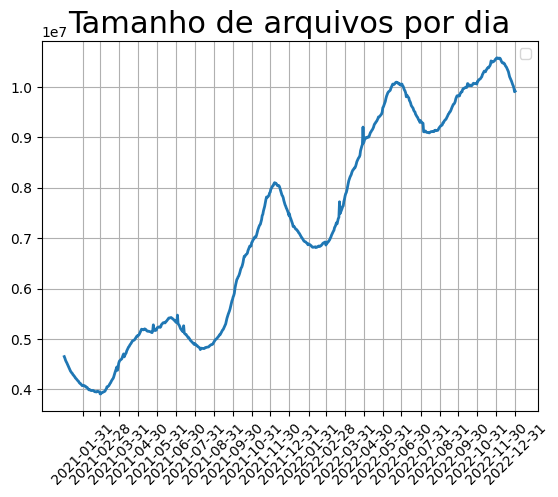

<Figure size 640x480 with 0 Axes>

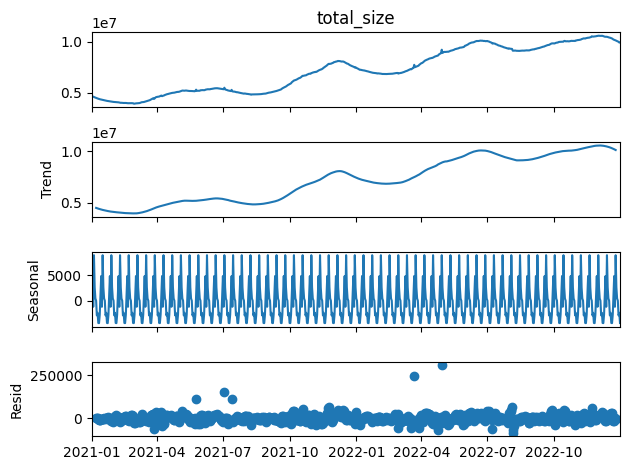

Exibindo dados para a tabela TAB000005
         total_size
count  7.290000e+02
mean   1.859032e+06
std    9.375823e+05
min    0.000000e+00
25%    1.095735e+06
50%    1.689254e+06
75%    2.634768e+06
max    4.182204e+06


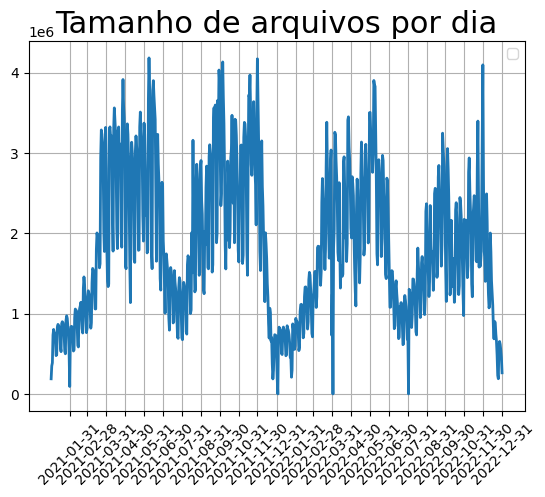

<Figure size 640x480 with 0 Axes>

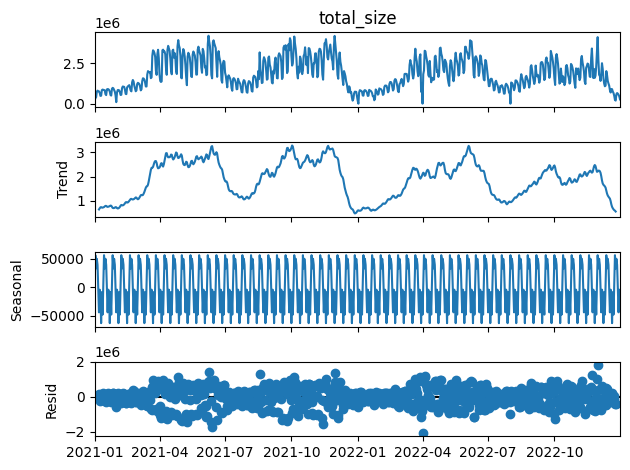

Exibindo dados para a tabela TAB000008
         total_size
count  7.290000e+02
mean   8.497642e+06
std    5.246547e+06
min    0.000000e+00
25%    4.844143e+06
50%    7.586879e+06
75%    1.051963e+07
max    3.502472e+07


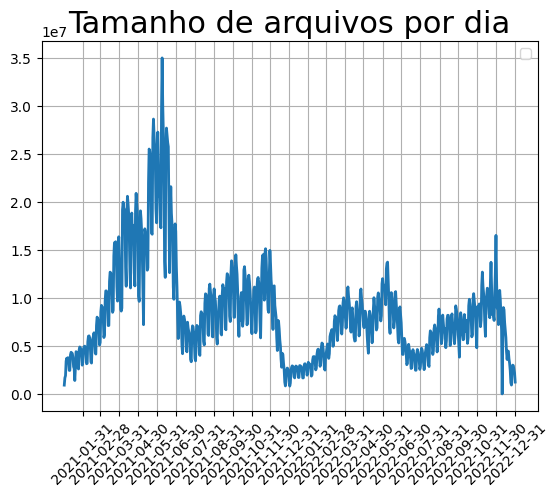

<Figure size 640x480 with 0 Axes>

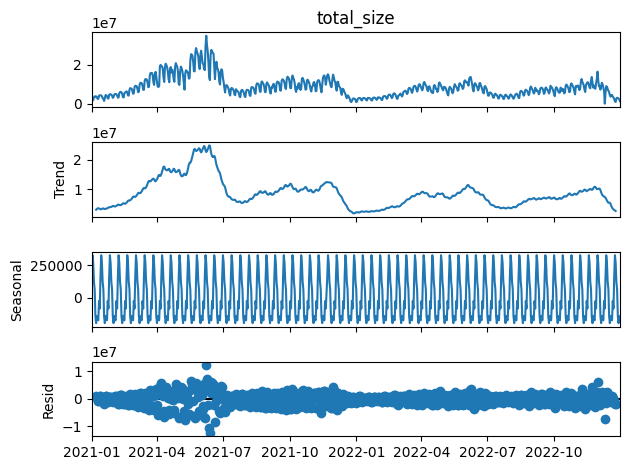

In [216]:
# Exibindo as time series

START_DATE_INTERVAL = "2021-01-01"
END_DATE_INTERVAL = "2022-12-31"

# Range de datas usadas para os rótulos dos gráficos no eixo X
timestamps = pd.date_range(start=START_DATE_INTERVAL, end=END_DATE_INTERVAL, freq="M", inclusive='both')
date_strings = [ts.strftime('%Y-%m-%d') for ts in timestamps]

for tab in tab_list:
    # Filtrando para trazer apenas uma tabela
    print(f"Exibindo dados para a tabela {tab}")
    data = df[df[TABLE_KEY] == tab].copy()
    data = data[(data[REF_DATE_KEY] >= START_DATE_INTERVAL) & (data[REF_DATE_KEY] <= END_DATE_INTERVAL)]
    plt.plot(data[REF_DATE_KEY], data[TOTAL_SIZE_KEY], linewidth = 2)
    plt.title('Tamanho de arquivos por dia', fontsize = 22)
    print(data.describe())
    plt.legend()
    plt.xticks(date_strings, rotation=45)
    plt.grid(True)
    plt.show()
    plt.clf()

    data = data.set_index(REF_DATE_KEY)
    data.index = pd.to_datetime(data.index)
    decomposition = seasonal_decompose(data[TOTAL_SIZE_KEY], model='additive', period=12)
    decomposition.plot()
    plt.show()

In [217]:
# Salvando arquivo modificado
df.to_csv(PROCESSED_METADATA_OUTLIERS_FILEPATH)